In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import os
import re
import requests

import matplotlib.pyplot as plt

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/pratice/clother'
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))

['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts', 'brown_pants', 'brown_shoes', 'brown_shorts', 'green_pants', 'green_shirt', 'green_shoes', 'green_shorts', 'red_dress', 'red_pants', 'red_shoes', 'white_dress', 'white_pants', 'white_shoes', 'white_shorts']
24


In [ ]:
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(data_dir):
    for name in files:
      images.append(os.path.join(path, name))
  return images

In [ ]:
classes = ['black', 'blue', 'brown', 'green', 'white', 'red', 'dress', 'pants', 'shorts', 'shoes', 'shirt']
len(classes)

11

In [ ]:
def encode_label(label, classes_list = classes):
    target = torch.zeros(11)
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target


def decode_target(target, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])
    return ' '.join(result)

In [ ]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = re.findall(r'\w+\_\w+', img_path)[0].split('_')

        return img, encode_label(label)

In [ ]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = re.findall(r'\w+\_\w+', img_path)[0].split('_')

        return img, encode_label(label)

In [ ]:
transform= T.Compose([T.Resize(128),
                      T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor()])

In [ ]:
dataset = myDataset(data_dir, transform = transform)
len(dataset)

11385

In [ ]:
dataset[1]

(tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 1.,  ..., 1., 1., 1.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.]]]),
 tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

Label: white shorts

tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])


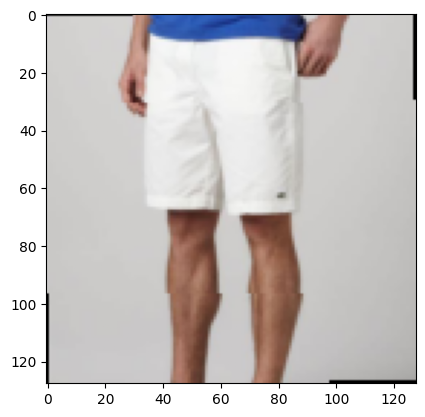

In [ ]:
def show_example(img,label):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*dataset[11380])

In [ ]:
val_percent = int(0.15 * len(dataset))
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size

(9678, 1707)

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9678, 1707)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([128, 3, 128, 128])
torch.Size([128, 11])


In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):

        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):

        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([128, 3, 128, 128])
torch.Size([128, 11])


In [ ]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,  opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in (train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(get_lr(optimizer))
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/pratice/model.pth')
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2


        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 11

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [ ]:
model = to_device(ResNet(3, len(classes)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fals

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 3, 128, 128])
outputs.shape :  torch.Size([128, 11])
Sample outputs :
 tensor([[0.3348, 0.5407, 0.7768, 0.1792, 0.5523, 0.7163, 0.1118, 0.6233, 0.9414,
         0.4940, 0.5559],
        [0.3470, 0.5037, 0.7867, 0.2999, 0.5004, 0.6225, 0.1375, 0.4500, 0.7538,
         0.4437, 0.4006]], device='cuda:0')


In [ ]:
epochs = 3
max_lr = 0.001


opt_func = torch.optim.Adam

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6930178999900818, 'val_score': 0.2512073814868927}]

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,

                         opt_func=opt_func)

Epoch [0], last_lr: 0.0010, train_loss: 0.2077, val_loss: 0.2139, val_score: 0.7804
Epoch [1], last_lr: 0.0005, train_loss: 0.0946, val_loss: 0.0712, val_score: 0.9252
Epoch [2], last_lr: 0.0000, train_loss: 0.0574, val_loss: 0.0505, val_score: 0.9510


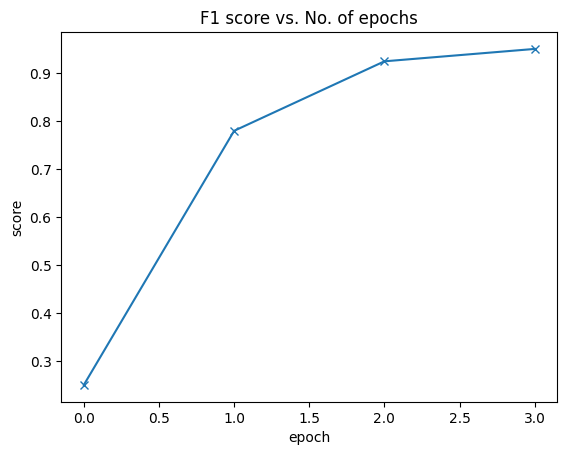

In [ ]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

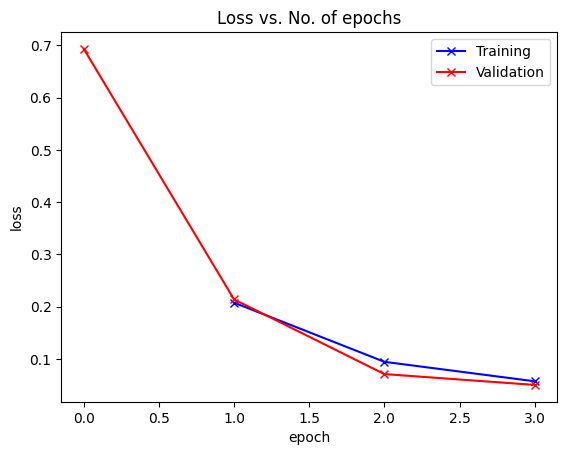

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Label: red dress

tensor([4.2952e-03, 9.0422e-04, 1.1945e-05, 1.5993e-05, 6.6295e-05, 9.9895e-01,
        9.9811e-01, 3.5590e-04, 7.9074e-05, 5.7361e-04, 9.6273e-04],
       device='cuda:0', grad_fn=<SelectBackward0>)


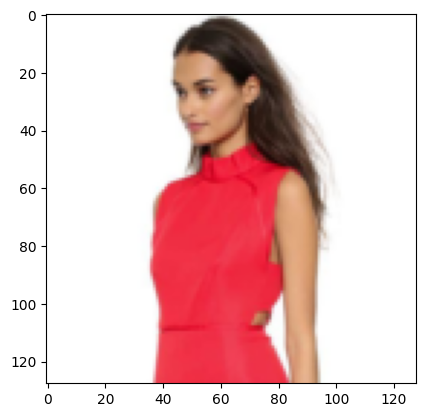

In [ ]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_ds[200][0]) #checking out the predictions of some images from the validation dataset.

Label: red pants

tensor([1.6525e-04, 1.4126e-04, 1.8285e-04, 1.1423e-04, 6.6971e-05, 9.9997e-01,
        2.3106e-04, 9.9636e-01, 4.7458e-05, 1.6670e-02, 1.2025e-04],
       device='cuda:0', grad_fn=<SelectBackward0>)


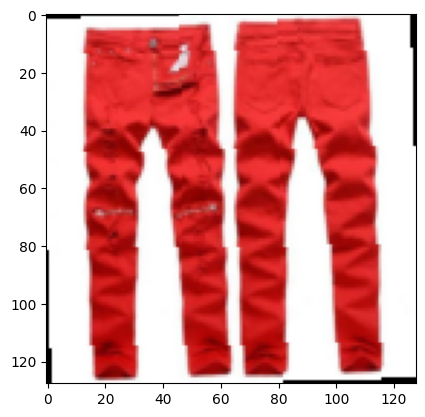

In [ ]:
predict_single(val_ds[100][0])

ggggffhfgggfffffdfeererndffd deffeedd